# Efectos Fijos

> I’m a traveler of both time and space <br>
> to be where I have been <br>
> To sit with elders of a gentle race <br>
> the world has seldom seen. <br>
> - _Led Zeppelin_

_Elaborado en el ejercicio del año sabático UJED_

La regresión lineal es un modelo muy importante porque permite establecer controles en nuestros datos. El problema es que depende de un supuesto clave: inconfundibilidad condicional:

$(Y_0,Y_1) \bot T | X$

En otras palabras, requiere que todas las variables de confusión sean conocidas y medidas. De tal manera que podamos incluirlas en el modelo y hacer que el grupo de tratamiento se comporte como si hubiera sido fruto de una asignación aleatoria. Pero, a pesar de que no siempre tenemos el lujo de que nuestras variables sean observables, siempre podemos agruparlos con características en común.

Ese es el problema que resuelven los modelos de datos en panel

## Cómo se ven los datos en panel

Imagina que estamos estudiando el efecto que hay entre el gasto en publicidad y los ingresos que nos genera.

Para ser mas claros, estamos haciendo una campaña para incrementar las ventas de una e-commerce por tres canales de venta. La primera es por anuncios de Google, el segundo con anuncios en Meta (que incluye Facebook e Instagram) y el tercero es por mail marketing.

Comencemos cargando nuestra base de datos en panel.

In [14]:
import pandas as pd
import statsmodels.formula.api as sm

df = pd.read_csv("../../../data/Panel/sales-panel.csv")
df.head()

Medio   Año  Ad cost  Sales
0  Google Ads  2020     1.25    3.4
1  Google Ads  2021     2.00   10.0
2  Google Ads  2022     6.00   13.5
3  Google Ads  2023     5.00    8.0
4  Google Ads  2024     6.00   11.0

Algunas observaciones sobre los datos:

- Estamos agrupando los datos por el medio en el que se hace la publicidad (Anuncios de Google, Anuncios de Facebook y una campaña de email marketing).
- El supuesto clave en estos datos es que los clientes que obtenemos a partir de medios diferentes son distintos entre sí. Este supuesto tiene sentido, simplemente porque se interactúa diferente en diferentes medios.
- Es un ejemplo simple, pero en realidad un análisis de panel como este podría ser muy útil para analizar campañas distintas que corren en paralelo.

Hagamos un diagrama de dispersión para analizar los datos.

Lo que deseamos conocer es el efecto que hay entre el costo de la publicidad y las ventas de esa campaña particular.

<ipython-input-24-a71c3eae8162>:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = df['Ad cost'][:, np.newaxis]  # X necesita ser 2D para np.polyfit


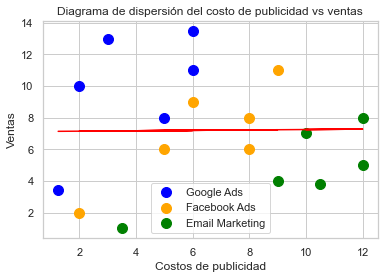

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear un diagrama de dispersión con diferentes colores para cada medio
colors = {
    'Google Ads': 'blue',
    'Facebook Ads': 'orange',
    'Email Marketing': 'green'
}
for medio in df['Medio'].unique():
    subset = df[df['Medio'] == medio]
    plt.scatter(subset['Ad cost'], subset['Sales'], s=100, label=medio, color=colors[medio])

# Calcular y trazar la línea de regresión
# Combinar todos los puntos sin importar el 'Medio' para la línea de regresión
X = df['Ad cost'][:, np.newaxis]  # X necesita ser 2D para np.polyfit
Y = df['Sales']
model = np.polyfit(X.flatten(), Y, 1)
predicted = np.polyval(model, X.flatten())
plt.plot(X.flatten(), predicted, color='red')

# Configurar el título y las etiquetas del gráfico
plt.title('Diagrama de dispersión del costo de publicidad vs ventas')
plt.xlabel('Costos de publicidad')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()



Le puse colores para que notes a simple vista: una regresión simple no es lo que deseamos hacer.

Si hiciéramos una regresión lineal simple tendríamos que nuestro gasto en publicidad no está aumentando las ventas. Al contrario, ¡Las está haciendo caer! Pero al separarlos por medio nos podemos dar cuenta de que no es así: cada una de las campañas de manera individual tiene un efecto positivo claro en las ventas.

Esto se ve más claro en el diagrama de dispersión.

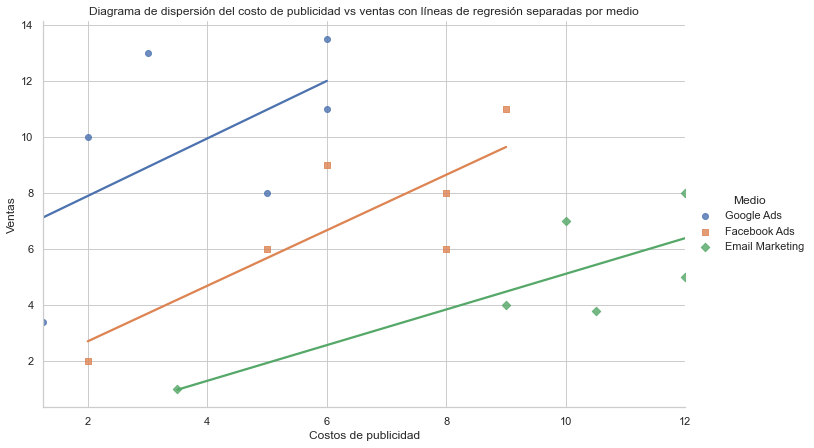

In [22]:
# Identificar los medios únicos para asegurarnos de asignar un marcador único para cada uno
unique_media = df['Medio'].unique()

# Crear un diagrama de dispersión con diferentes marcadores para cada medio y líneas de regresión separadas
sns.lmplot(x='Ad cost', y='Sales', data=df, hue='Medio', markers=['o', 's', 'D', '^'][:len(unique_media)], height=6, aspect=1.6, ci=None)

# Configurar el título y las etiquetas del gráfico
plt.title('Diagrama de dispersión del costo de publicidad vs ventas con líneas de regresión separadas por medio')
plt.xlabel('Costos de publicidad')
plt.ylabel('Ventas')
plt.show()



## Los efectos fijos son sólo una aglomeración de variables de control en una sola

La clave de los efectos fijos es que:

- Podemos incluir el efecto del tiempo en nuestro modelo, pero el tiempo en si mismo no es una variable.
- Lo que importa es que estamos capturando todas las características intrínsecas de nuestro medio y estamos asumiendo que son “fijas”.

El modelo de efectos fijos se define en términos generales como

$$
Y_{it} = \beta X_{it} + \gamma U_i + \varepsilon_{it}
$$

donde $Y_{it}$ es el resultado que tiene el individuo $i$ en el tiempo $t$, que puede medirse en meses, años, trimestres o lo que sea que tenga sentido. Nuevamente, $X_{it}$ es el vector de variables para el individuo $i$ en el tiempo $t$.

Nota que ahora incluimos una variable $U_i$.

Esta representa el conjunto de inobservables del individuo $i$ (la u es porque en inglés se dice *unobservables*). Nota que este elemento no tiene subíndice $t$, porque asumimos que estos inobservables no cambian en el tiempo. Por ejemplo, en una campaña de anuncios de google podemos asumir que el algoritmo que subasta un término de búsqueda es el mismo para todas las observaciones que hacemos.

## Variación dentro del individuo

En teoría, los efectos fijos funcionan igual que si usáramos una variable dummy para cada uno de los individuos (menos uno).

El problema es que no es raro que nuestro panel se componga de más de 3 variables como en el ejemplo. Imaginemos que estamos tratando de hacer un panel para una campaña gigantesca ultrasegmentada de contenido con facebook ads. Una campaña así funcionaría haciendo un anuncio para cada pieza de contenido que hacemos, pautando (haciendo publicidad) y dejando que el algoritmo de meta encuentre a los consumidores ideales de ese contenido. Lo que obtenemos es una campaña para cada pieza de contenido que corren en paralelo. Esto puede hacer que el tamaño de nuestra base de datos aumente muy rápido.

Por eso hacemos un pequeño truco que nos permite obtener el mismo resultado que si usaramos variables dummy, pero con un conjunto más manejable de datos.

El primer paso es obtener las medias de nuestras variables. Así las vemos visualmente.

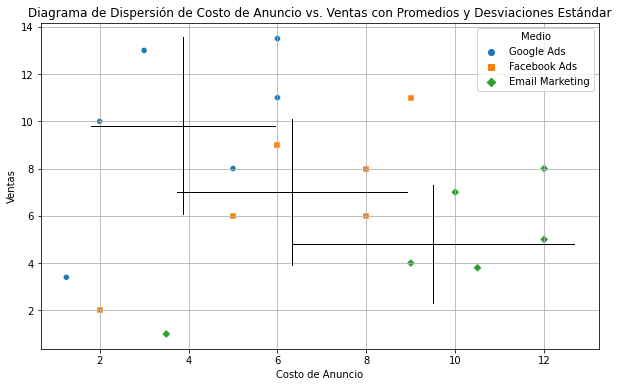

In [9]:
# Calculando el promedio y la desviación estándar del costo de anuncios y las ventas para cada medio
media_stats = df.groupby('Medio').agg({'Ad cost': ['mean', 'std'], 'Sales': ['mean', 'std']}).reset_index()

# Creando el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ad cost', y='Sales', data=df, hue='Medio', style='Medio', markers=['o', 's', 'D'][:len(unique_media)])

# Añadiendo las líneas para representar el promedio ± una desviación estándar
for _, row in media_stats.iterrows():
    medio = row['Medio']
    ad_cost_mean = row[('Ad cost', 'mean')]
    ad_cost_std = row[('Ad cost', 'std')]
    sales_mean = row[('Sales', 'mean')]
    sales_std = row[('Sales', 'std')]
    
    # Dibujando líneas para el costo de anuncios
    plt.plot([ad_cost_mean - ad_cost_std, ad_cost_mean + ad_cost_std], [sales_mean, sales_mean], 
             color='black', linestyle='-', linewidth=1)
    
    # Dibujando líneas para las ventas
    plt.plot([ad_cost_mean, ad_cost_mean], [sales_mean - sales_std, sales_mean + sales_std], 
             color='black', linestyle='-', linewidth=1)

plt.title('Diagrama de Dispersión de Costo de Anuncio vs. Ventas con Promedios y Desviaciones Estándar')
plt.xlabel('Costo de Anuncio')
plt.ylabel('Ventas')
plt.legend(title='Medio')
plt.grid(True)
plt.show()


El siguiente paso es restar estas medias de nuestros individuos.

$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_{i} \\ \ddot{X}_{it} = X_{it} - \bar{X}_{i}
$$

Visualmente lo que esto logra es como si “empalmaramos” las cruces que se formaron en el gráfico anterior.

Ahora sólo tenemos que hacer una regresión de $\ddot Y_{it}$ contra $\ddot X_{it}$, o bien

$$
(Y_{it} - \bar Y_i) = \beta(X_{it} - \bar X_{i}) + (\varepsilon_{it} - \bar \varepsilon_{i}) \\ \ddot Y_{it} = \beta \ddot X_{it} + \ddot\varepsilon_{it}
$$

Nota que el término de elementos inobservables desaparece. Esto es porque $U_i = \bar U_i$, por su propia definición. Es una operación que elimina todos los términos constantes en el tiempo.

Visualmente, la regresión sería esta.

In [10]:
df['Within Ad cost'] = df.groupby('Medio')['Ad cost'].transform(lambda x: x - x.mean())
df['Sales Within'] =  df.groupby('Medio')['Sales'].transform(lambda x: x - x.mean())
df.head()

Medio   Año  Ad cost  Sales  Within Ad cost  Sales Within
0  Google Ads  2020     1.25    3.4          -2.625     -6.416667
1  Google Ads  2021     2.00   10.0          -1.875      0.183333
2  Google Ads  2022     6.00   13.5           2.125      3.683333
3  Google Ads  2023     5.00    8.0           1.125     -1.816667
4  Google Ads  2024     6.00   11.0           2.125      1.183333

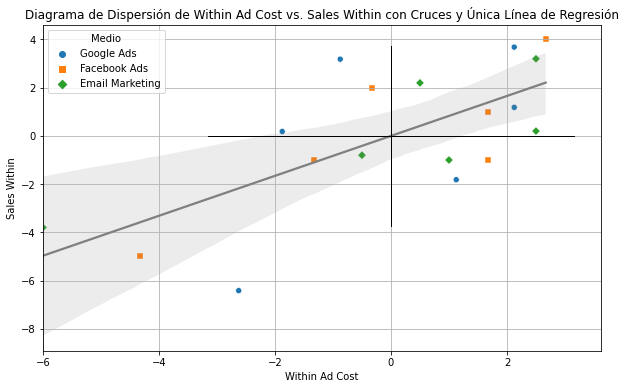

In [11]:
# Calculando las estadísticas necesarias para los cruces en el gráfico
media_within_stats = df.groupby('Medio').agg({'Within Ad cost': ['mean', 'std'], 'Sales Within': ['mean', 'std']}).reset_index()

# Creando el gráfico con las variables "Within"
plt.figure(figsize=(10, 6))

# Usando scatterplot para los puntos con color, pero sin añadir la línea de regresión aquí
sns.scatterplot(x='Within Ad cost', y='Sales Within', data=df, hue='Medio', style='Medio', markers=['o', 's', 'D'][:len(df['Medio'].unique())])

# Añadiendo la línea de regresión con regplot
sns.regplot(x='Within Ad cost', y='Sales Within', data=df, scatter=False, color='gray')

# Añadiendo las cruces que representan la media ± una desviación estándar para las variables within
for _, row in media_within_stats.iterrows():
    medio = row['Medio']
    within_ad_cost_mean = row[('Within Ad cost', 'mean')]
    within_ad_cost_std = row[('Within Ad cost', 'std')]
    sales_within_mean = row[('Sales Within', 'mean')]
    sales_within_std = row[('Sales Within', 'std')]
    
    # Dibujando líneas para Within Ad cost
    plt.plot([within_ad_cost_mean - within_ad_cost_std, within_ad_cost_mean + within_ad_cost_std], [sales_within_mean, sales_within_mean], 
             color='black', linestyle='-', linewidth=1)
    
    # Dibujando líneas para Sales Within
    plt.plot([within_ad_cost_mean, within_ad_cost_mean], [sales_within_mean - sales_within_std, sales_within_mean + sales_within_std], 
             color='black', linestyle='-', linewidth=1)

plt.title('Diagrama de Dispersión de Within Ad Cost vs. Sales Within con Cruces y Única Línea de Regresión')
plt.xlabel('Within Ad Cost')
plt.ylabel('Sales Within')
plt.legend(title='Medio')
plt.grid(True)
plt.show()


Nota cómo ahora las medias están en cero en los dos ejes. 

Ahora todos los datos están en un punto comparable. A esto se le llama “absorber” los efectos fijos.

Naturalmente, ahora podemos aplicar una regresión lineal simple a nuestros datos.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the formula for the fixed effects model using the demeaned variables
formula = 'Q("Sales Within") ~ Q("Within Ad cost")'

# Fit the fixed effects model
model = smf.ols(formula, data=df).fit()

# Display the summary of the regression results
model.summary()

/Users/mario/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q("Sales Within")   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     14.96
Date:                Wed, 29 May 2024   Prob (F-statistic):            0.00136
Time:                        09:07:24   Log-Likelihood:                -38.610
No. Observations:                  18   AIC:                             81.22
Df Residuals:                      16   BIC:                             83.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept                    0      0.517          0      1.000      -1.095       1.095
Q("Within Ad cost")     0.8283      0.214      3.868      0.001       0.374       1.282
==============================================================================
Omnibus:                        0.334   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.846   Jarque-Bera (JB):                0.487
Skew:                          -0.177   Prob(JB):                        0.784
Kurtosis:                       2.275   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Y listo.

La regresión sobre nuestros datos centrados es una regresión lineal simple. Podemos observar que la relación entre la publicidad y las ventas es positiva.

Este es un modelo sencillo con sólo dos variables. En modelos más complejos, querrás usar paquetería especializada para el manejo de datos en panel.

Este es el código usando `PanelOLS`, del módulo `linearmodels`.

In [13]:
from linearmodels.panel import PanelOLS

# Preparing the data: Setting 'Medio' and 'Año' as index
df_panel = df.set_index(['Medio', 'Año'])

# Specifying and fitting the model with entity effects (fixed effects)
panel_model = PanelOLS.from_formula('Sales ~ Q("Ad cost") + EntityEffects', data=df_panel)

# Fitting the model
panel_results = panel_model.fit()

# Displaying the results
panel_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                  Sales   R-squared:                        0.4832
Estimator:                   PanelOLS   R-squared (Between):              0.6666
No. Observations:                  18   R-squared (Within):               0.4832
Date:                Wed, May 29 2024   R-squared (Overall):              0.6431
Time:                        09:07:29   Log-likelihood                   -38.610
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      13.092
Entities:                           3   P-value                           0.0028
Avg Obs:                       6.0000   Distribution:                    F(1,14)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             13.092
                                        P-value                           0.0028
Time periods:                       6   Distribution:                    F(1,14)
Avg Obs:                       3.0000                                           
Min Obs:                       3.0000                                           
Max Obs:                       3.0000                                           
                                                                                
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Q('Ad cost')     0.8283     0.2289     3.6183     0.0028      0.3373      1.3194
================================================================================

F-test for Poolability: 13.450
P-value: 0.0006
Distribution: F(2,14)

Included effects: Entity
"""

## El efecto fijo de dos vías

Digamos que queremos hacer lo mismo no sólo para los individuos, sino también para el tiempo.

El resultado sería un modelo como este:

$$
Y_{it} = U_i + U_t + \beta X_{it} + \varepsilon_{it}
$$

Lo que este modelo nos da es una estimación que permite comparar la variación *entre individuos* al mismo tiempo que *entre años*.

Por ejemplo, nota que en los datos anteriores, las ventas del año 2020 son relativamente más bajas que las demás. Es un recordatorio de la época de pandemia, en la que cerraron todos los negocios y las ventas de muchas cosas bajaron, a menos de que vendas cubrebocas. En el caso de las ventas por Facebook, 3.4 es muy bajo para lo que estamos acostumbrados a vender por ese medio, pero no es un nivel de ventas tan fuera de lo normal para el marketing por e-mail.

Usa este código para hacer una regresión de panel por dos vías.

In [27]:
from linearmodels.panel import PanelOLS

# Efectos fijos de dos vias
model = PanelOLS.from_formula('Sales ~ Q("Ad cost") + EntityEffects + TimeEffects', data=df_panel)
results = model.fit()
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  Sales   R-squared:                        0.0084
Estimator:                   PanelOLS   R-squared (Between):             -0.1419
No. Observations:                  18   R-squared (Within):              -0.1093
Date:                Tue, Apr 02 2024   R-squared (Overall):             -0.1377
Time:                        18:57:54   Log-likelihood                   -25.865
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0763
Entities:                           3   P-value                           0.7886
Avg Obs:                       6.0000   Distribution:                     F(1,9)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             0.0763
                            

## Referencias
Cunningham, S. (2021). _Causal Inference: The Mixtape_.
Huntington-Klein, N. (2022). _The Effect: An Introduction to Research Design and Causality_.
Facure Alves, M. (2022). _Causal Inference for the Brave and True_.
---

## Como citar este libro

Cita en APA (7a edición)

```
García Meza, M. A. (2024). *Inferencia causal para negocios: Una guía práctica con Python*. https://inferenciacausal.com
```

Cita en MLA (9a edición)

```
García Meza, Mario A. *Inferencia Causal para Negocios: Una Guía Práctica con Python*. Durango, México, 2024. https://inferenciacausal.com.
```

Cita en Chicago

```
García Meza, Mario A. I*nferencia Causal para Negocios: Una Guía Práctica con Python*. Durango, México, 2024. https://inferenciacausal.com.
```


_Espero que este libro te resulte útil._

_Si eres economista y deseas escribir tu primer paper de economía, hice este curso gratis por correo justo para tí._

_En este curso aprenderás a:_

* _Crear objetivos de investigación que tienen sentido, que ningún juez te podrá "tumbar"._
* _Usar causalidad en tus modelos y no sólo seguir una receta de cocina para trabajar con datos._
* _Apoyarte de otras personas y la tecnología para escribir al menos dos papers al año, todos los años, consistentemente y para siempre._

<div style="text-align: center; margin-top: 20px;">
  <a href="https://guiaeconomista.com" target="_blank" style="background-color: #154957; color: #FFFFFF; padding: 10px 20px; text-decoration: none; border-radius: 5px; font-size: 16px;">
    Descarga La Guía del Economista aquí
  </a>
</div>


<iframe src="https://guiaeconomista.com/#form" width="400" height="300" style="border: none;"></iframe>

<div style="height: 100vh"><script src="https://cdn.jsdelivr.net/ghost/signup-form@~0.1/umd/signup-form.min.js" data-label-1="inferenciacausal.com" data-background-color="#ffffff" data-text-color="#000000" data-button-color="#154957" data-button-text-color="#FFFFFF" data-title="Escribe tu primer paper de Economía" data-description="Todos los meses recibe un tutorial de econometría, un análisis de un artículo y una guía" data-icon="https://marionomics.com/content/images/size/w192h192/size/w256h256/2024/08/2.svg" data-site="https://marionomics.com/" data-locale="es" async></script></div>

_Elaborado en el ejercicio de año sabático UJED_